In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
FSLogix,579.686369,24.153599,24
Search Engine Optimization,583.284141,97.214024,6
Powershell,624.155903,52.012992,12
JavaScript Concepts,760.926423,10.717274,71
Audit Report Tracker (Sharepoint List),815.797488,50.987343,16
Azure Functions + Visual Studio,840.813747,60.058125,14
Email Auth and Security,872.288465,67.099113,13
DNS,989.458329,61.841146,16
OData,1003.487984,66.899199,15
Home Network Project,1087.497911,57.236732,19


# Histogram

39193.90


<Axes: >

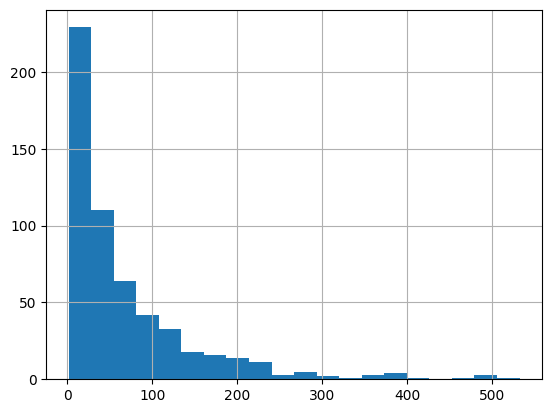

In [4]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [13]:
# n=5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [14]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [15]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 561


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
69,Azure Functions + PP365,Azure Resource Manager (ARM) Templates\nJSON f...,55f4e6729328a01289468a2cd32e2e0a,-532.490468,88.194793,-532.490468,3263.207325,0.621947,0,0
147,Azure Functions + PP365,GitHub Actions\nAn automation tool integrated ...,b037e088126fccfdab0fb7d0e8cf74ba,-215.034702,88.194793,-532.490468,3263.207325,0.621947,3,0
222,Azure Functions + PP365,Cold Start\nThe latency experienced when an Az...,e4c2d18cab9ed22292bc930e17fb4b5f,-129.448586,88.194793,-532.490468,3263.207325,0.621947,6,0
296,Azure Functions + PP365,Scopes\nPermissions in OAuth 2.0 that specify ...,a9df6e4244234478b327fd17f1caf6a5,-86.204981,88.194793,-532.490468,3263.207325,0.621947,9,0
363,Azure Functions + PP365,XMLHttpRequest\nA JavaScript API used to send ...,9eb3af138e75be30ff83ed17f8324c60,-71.733902,88.194793,-532.490468,3263.207325,0.621947,12,0
408,Azure Functions + PP365,Logging\nThe practice of recording information...,811ce272b3cf5bff2fdcb5a7ce09c45b,-62.014867,88.194793,-532.490468,3263.207325,0.621947,15,0
442,Azure Functions + PP365,Azure Function App Logs\nLogs generated by Azu...,fc502a0ad47e15d3be8d28df63c69cfb,-50.644995,88.194793,-532.490468,3263.207325,0.621947,18,0
468,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f0738c66ae6f3de6f880ac7c2431633f,-44.702460,88.194793,-532.490468,3263.207325,0.621947,21,0
484,Azure Functions + PP365,OAuth 2.0 Authentication Flow\nA sequence of s...,5dd24066118d64f74295ebed091fa677,-34.358461,88.194793,-532.490468,3263.207325,0.621947,24,0
496,Azure Functions + PP365,Local Debugging\nRunning and testing Azure Fun...,cef2a4ff8162c1613bdadb864f34ed66,-24.446996,88.194793,-532.490468,3263.207325,0.621947,27,0


## Card Count

In [16]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [17]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
69,Azure Functions + PP365,Azure Resource Manager (ARM) Templates\nJSON f...,55f4e6729328a01289468a2cd32e2e0a,-532.490468,88.194793,-532.490468,3263.207325,0.621947,0,0
147,Azure Functions + PP365,GitHub Actions\nAn automation tool integrated ...,b037e088126fccfdab0fb7d0e8cf74ba,-215.034702,88.194793,-532.490468,3263.207325,0.621947,3,0
222,Azure Functions + PP365,Cold Start\nThe latency experienced when an Az...,e4c2d18cab9ed22292bc930e17fb4b5f,-129.448586,88.194793,-532.490468,3263.207325,0.621947,6,0
296,Azure Functions + PP365,Scopes\nPermissions in OAuth 2.0 that specify ...,a9df6e4244234478b327fd17f1caf6a5,-86.204981,88.194793,-532.490468,3263.207325,0.621947,9,0
363,Azure Functions + PP365,XMLHttpRequest\nA JavaScript API used to send ...,9eb3af138e75be30ff83ed17f8324c60,-71.733902,88.194793,-532.490468,3263.207325,0.621947,12,0
408,Azure Functions + PP365,Logging\nThe practice of recording information...,811ce272b3cf5bff2fdcb5a7ce09c45b,-62.014867,88.194793,-532.490468,3263.207325,0.621947,15,0
442,Azure Functions + PP365,Azure Function App Logs\nLogs generated by Azu...,fc502a0ad47e15d3be8d28df63c69cfb,-50.644995,88.194793,-532.490468,3263.207325,0.621947,18,0
468,Azure Functions + PP365,Virtual Environment Activation\nThe process of...,f0738c66ae6f3de6f880ac7c2431633f,-44.702460,88.194793,-532.490468,3263.207325,0.621947,21,0
484,Azure Functions + PP365,OAuth 2.0 Authentication Flow\nA sequence of s...,5dd24066118d64f74295ebed091fa677,-34.358461,88.194793,-532.490468,3263.207325,0.621947,24,0
496,Azure Functions + PP365,Local Debugging\nRunning and testing Azure Fun...,cef2a4ff8162c1613bdadb864f34ed66,-24.446996,88.194793,-532.490468,3263.207325,0.621947,27,0


In [18]:
existing_cards['age'].mean()

-69.86434190407493